---

# Predicting the 10-Year Treasury Yield Using Macroeconomic Indicators and Gradient Boosting Regression

In this notebook, we will use gradient boosting regression to predict the 10-Year U.S. Treasury Yield based on a selection of macroeconomic indicators. Our goal is to evaluate whether a nonlinear ensemble model can effectively capture the complex relationships between economic conditions and long-term interest rates.

Gradient boosting is an ensemble learning method that builds models sequentially, where each new model attempts to correct the residual errors made by the previous ones. Specifically, gradient boosting fits decision trees to the negative gradients (i.e., the residuals) of a loss function, improving accuracy in a stage-wise fashion. It is particularly well-suited for tabular data with heterogeneous features and complex interactions.

We will be using publicly available data from the Federal Reserve Economic Data (FRED) repository. The features include:

- GDP: Gross Domestic Product

- UNRATE: Unemployment rate

- CPI: Consumer Price Index (inflation proxy)

- FEDFUNDS: Federal Funds Rate

- M2: Broad money supply

- SP500: S&P 500 index

- Y10 (target): 10-Year Treasury Constant Maturity Rate

After preprocessing and aligning the dataset, we will train a GradientBoostingRegressor from scikit-learn, evaluate its performance, and interpret feature importance to understand which indicators contribute most to yield prediction. Begin by importing the relevant libraries:

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


---

Next, load in the datasets and compile them into a single dataframe. The CSV files can be found attached in the 'data' folder within this repo.

---

In [8]:
files = {
    'GDP.csv': 'GDP',
    'UNRATE.csv': 'UNRATE',
    'CPIAUCSL.csv': 'CPI',
    'FEDFUNDS.csv': 'FEDFUNDS',
    'M2SL.csv': 'M2',
    'SP500.csv': 'SP500',
    'GS10.csv': 'Y10'
}

dfs = []
for file, colname in files.items():
    df = pd.read_csv(f'data/{file}', parse_dates=['observation_date'])
    df.rename(columns={'observation_date': 'DATE', df.columns[1]: colname}, inplace=True)
    dfs.append(df)

from functools import reduce
data = reduce(lambda left, right: pd.merge(left, right, on='DATE', how='inner'), dfs)
data.set_index('DATE', inplace=True)

data


,GDP,UNRATE,CPI,FEDFUNDS,M2,SP500,Y10
DATE,,,,,,,
2015-07-01,18401.626,5.2,238.034,0.13,12049.2,2077.42,2.32
2015-10-01,18435.137,5.0,237.733,0.12,12206.1,1923.82,2.07
2016-01-01,18525.933,4.8,237.652,0.34,12506.0,NaN,2.09
2016-04-01,18711.702,5.1,238.992,0.37,12708.0,2072.78,1.81
2016-07-01,18892.639,4.8,240.101,0.39,12889.7,2102.95,1.50
2018-01-01,20328.553,4.0,248.859,1.41,13883.2,NaN,2.58
2018-10-01,20917.867,3.8,252.772,2.19,14241.4,2924.59,3.15
2019-01-01,21111.600,4.0,252.561,2.40,14446.1,NaN,2.71
2019-04-01,21397.938,3.7,255.233,2.42,14554.5,2867.19,2.53


---

Next, we make sure that our data is properly processed by converting all times to monthly and removing any missing data.

---

In [12]:
# Forward-fill missing values (monthly → quarterly mismatch etc.)
data = data.fillna(method='ffill').dropna()
data = data.resample('M').mean()  # Convert to monthly

# Drop rows with any remaining NaNs
data.dropna(inplace=True)

data


C:\Users\kylej\AppData\Local\Temp\ipykernel_58928\3933339088.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').dropna()
C:\Users\kylej\AppData\Local\Temp\ipykernel_58928\3933339088.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = data.resample('M').mean()  # Convert to monthly


,GDP,UNRATE,CPI,FEDFUNDS,M2,SP500,Y10
DATE,,,,,,,
2015-07-31,18401.626,5.2,238.034,0.13,12049.2,2077.42,2.32
2015-10-31,18435.137,5.0,237.733,0.12,12206.1,1923.82,2.07
2016-01-31,18525.933,4.8,237.652,0.34,12506.0,1923.82,2.09
2016-04-30,18711.702,5.1,238.992,0.37,12708.0,2072.78,1.81
2016-07-31,18892.639,4.8,240.101,0.39,12889.7,2102.95,1.50
2018-01-31,20328.553,4.0,248.859,1.41,13883.2,2102.95,2.58
2018-10-31,20917.867,3.8,252.772,2.19,14241.4,2924.59,3.15
2019-01-31,21111.600,4.0,252.561,2.40,14446.1,2924.59,2.71
2019-04-30,21397.938,3.7,255.233,2.42,14554.5,2867.19,2.53


---

Separate the target from the feature vectors.

---

In [13]:
X = data.drop(columns='Y10')  # All but the 10-year yield
y = data['Y10']

---

Properly split the data into training and testing sets.

---

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False  # no shuffle = time series style
)

# Optional scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

---

We can now train our gradient boosting regressor! We will use the one provided by the sklearn library with 200 estimators, a learning rate of 0.05, and a maximum depth of 4.

---

In [15]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42
)
gbr.fit(X_train_scaled, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=4, n_estimators=200,
                          random_state=42)

---

We can now apply our regressor to our test set and analyze its predictions from 2021 onwards.

---

R² Score: -0.715
RMSE: 0.855


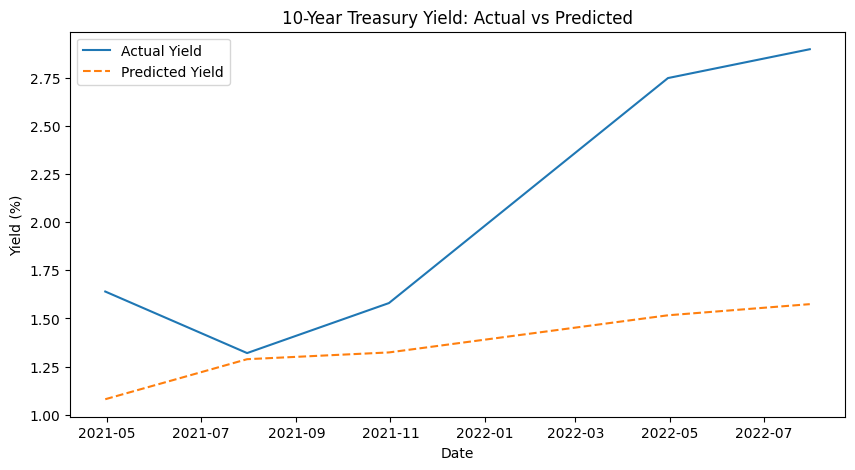

In [16]:
y_pred = gbr.predict(X_test_scaled)

print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Actual Yield')
plt.plot(y_test.index, y_pred, label='Predicted Yield', linestyle='--')
plt.title("10-Year Treasury Yield: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Yield (%)")
plt.legend()
plt.show()

---

While our model was roughly accurate for the first half of its predictions, it vastly underestimated the yield rate going into 2022. This is likely because there was unprecedented economic growth following Covid, which a model (especially with a relatively low sample) would find difficult to predict in any case. Regardless, we can analyze the importances that the model learned during training.

---

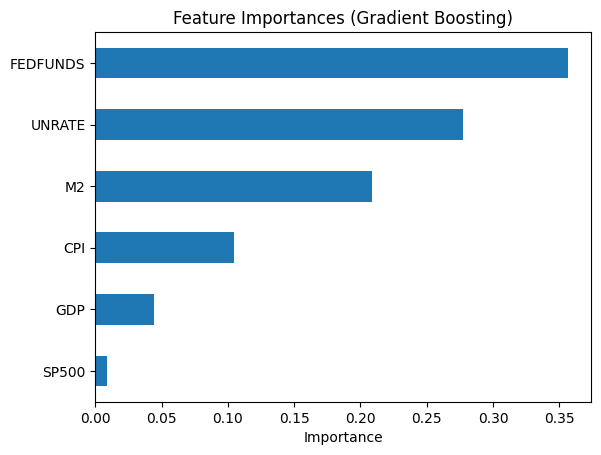

In [17]:
importances = pd.Series(gbr.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).plot(kind='barh')
plt.title("Feature Importances (Gradient Boosting)")
plt.xlabel("Importance")
plt.show()


---

The model determined that the federal funds rate was the most important factor in determining 10-year treasury yield, while the S&P 500 held almost no importance. This makes sense, as the federal funds rate is often a more proactive measure (i.e., it sets the course of the economy) while the S&P 500 is more reactive and volatile. 

Regardless, we have seen how gradient boosting is a powerful algorithm for regressing across many dimensions without much linearity, and can become even more accurate given better training sets.

---